In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Multiply, Subtract, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, Dropout, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D, Reshape
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing import image
# from tensorflow.keras.utils import layer_utils
# from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input

%matplotlib inline

from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
# from keras.utils import plot_model
#from resnets_utils import *
from keras.initializers import glorot_uniform, he_normal
import scipy.misc
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline
import keras.backend as K
K.set_image_data_format('channels_last') 
# K.set_learning_phase(1) 
import scipy
import cv2
from keras.layers import subtract
import keras
from keras.layers import Lambda
import tensorflow as tf 
from tensorflow.keras.optimizers import Adam,RMSprop 

from tensorflow import image
from tensorflow.keras.utils import *

from PIL import Image,ImageOps

import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

RANDOM_SEED = 42
LABELS = ["genunine", "forged"]

2023-12-10 17:48:56.361767: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-10 17:49:01.124794: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 17:49:01.124880: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 17:49:01.686033: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 17:49:03.229830: I tensorflow/core/platform/cpu_feature_guar

In [23]:
def preprocess(img_input):
	img_input=cv2.resize(img_input,SIZE,interpolation=cv2.INTER_LINEAR)

	# ------------------------------
	#Only black or white pixels
	bw_pixels = np.where(img_input < 128, 0, 255)
	bw_image = bw_pixels.reshape((155, 220, 3))
	img_input = bw_image
	# Rescaling the intensity
	pmin, pmax = img_input.min(), img_input.max()
	if pmin == pmax or np.isnan(pmin) or np.isnan(pmax):
		rescaled_image = img_input  # or set it to a default value
	else:
		rescaled_image = 255 * (img_input - pmin) / (pmax - pmin)
	rescaled_pixels = rescaled_image.flatten()
	img_input = rescaled_pixels
	# ------------------------------

	img_input=img_input/255
	return img_input

def contrastive_loss(y, preds, margin=1):
	# explicitly cast the true class label data type to the predicted
	# class label data type (otherwise we run the risk of having two
	# separate data types, causing TensorFlow to error out)
	y = tf.cast(y, preds.dtype)
	# calculate the contrastive loss between the true labels and
	# the predicted labels
	squaredPreds = K.square(preds)
	squaredMargin = K.square(K.maximum(margin - preds, 0))
	loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
	# return the computed contrastive loss to the calling function
	return loss

In [5]:
SIZE=(220,155)
# input_shape=(155,230,3)

## Load Data

In [16]:
# org_list_1=[]
# for i in range(55):
#     p=[]
#     for j in range(24):
#         img_path = '/u/epw9kz/academic/first_year/ML/project/bonus/dataset/2_CEDAR/signatures/full_forg/forgeries_'+str(i+1) +'_' +str(j+1)+'.png'
#         img = load_img(img_path,target_size=(155,220), color_mode='grayscale') 
#         x = img_to_array(img)
#         if i == 0 and j == 0:
#             print('img x', x.shape)
#             break

img x (155, 220, 1)


In [24]:
forg_list_1=[]
for i in range(55):
    p=[]
    for j in range(24):
        img_path = '/u/epw9kz/academic/first_year/ML_bonus/bonus/dataset/2_CEDAR/signatures/full_forg/forgeries_'+str(i+1) +'_' +str(j+1)+'.png'
        img = load_img(img_path,target_size=(155,220)) 
        x = img_to_array(img)
        x=preprocess(x)
        p.append(x)
    forg_list_1.append(p)

org_list_1=[]
for i in range(55):
    p=[]
    for j in range(24):
        img_path = '/u/epw9kz/academic/first_year/ML_bonus/bonus/dataset/2_CEDAR/signatures/full_org/original_'+str(i+1) +'_' +str(j+1)+'.png'
        img = load_img(img_path,target_size=(155,220)) 
        x = img_to_array(img)
        x=preprocess(x)
        p.append(x)
    org_list_1.append(p)

print(len(forg_list_1))

55


In [25]:
frauds = np.asarray(forg_list_1)
normal = np.asarray(org_list_1)

print(frauds.shape)
print(normal.shape)

frauds = frauds.reshape(-1, SIZE[1], SIZE[0], 3)
normal = normal.reshape(-1, SIZE[1], SIZE[0], 3)

print(frauds.shape)
print(normal.shape)

(55, 24, 102300)
(55, 24, 102300)
(1320, 155, 220, 3)
(1320, 155, 220, 3)


## Preparing the Data

In [27]:
working_X_train_frauds, reserved_X_test_frauds = train_test_split(frauds, test_size=0.95, random_state=RANDOM_SEED)
working_X_train_normal, reserved_X_test_normal = train_test_split(normal, test_size=0.15, random_state=RANDOM_SEED)

# preparing unseend test data (fraud + normal)
reserved_X_test = np.concatenate([reserved_X_test_frauds, reserved_X_test_normal])
frauds_length = len(reserved_X_test_frauds)
normal_length = len(reserved_X_test_normal)
reserved_y_test = np.concatenate([np.ones(frauds_length), np.zeros(normal_length)])

indices = np.arange(len(reserved_X_test))
np.random.shuffle(indices)
reserved_X_test = reserved_X_test[indices]
reserved_y_test = reserved_y_test[indices]

print('unseen test data', reserved_X_test.shape, reserved_y_test.shape)

# preparing train (only normal), test (only normal), validation (fraud + normal) data
X_valid_train_normal, X_test = train_test_split(working_X_train_normal, test_size=0.15, random_state=RANDOM_SEED)

X_valid_frauds = working_X_train_frauds
X_train, X_valid_normal = train_test_split(X_valid_train_normal, test_size=0.2, random_state=RANDOM_SEED)
print('--------******   valid dist', X_valid_frauds.shape, X_valid_normal.shape)

X_valid = np.concatenate([X_valid_frauds, X_valid_normal])
frauds_length = len(X_valid_frauds)
normal_length = len(X_valid_normal)
y_valid = np.concatenate([np.ones(frauds_length), np.zeros(normal_length)])

indices = np.arange(len(X_valid))
np.random.shuffle(indices)
X_valid = X_valid[indices]
y_valid= y_valid[indices]

print('train data', X_train.shape)
print('validation data', X_valid.shape, y_valid.shape)
print('test data', X_test.shape)

unseen test data (1452, 155, 220, 3) (1452,)
--------******   valid dist (66, 155, 220, 3) (191, 155, 220, 3)
train data (762, 155, 220, 3)
validation data (257, 155, 220, 3) (257,)
test data (169, 155, 220, 3)


## Building the Model

In [28]:
input_dim = X_train.shape[1:]
flattened_input_shape = np.prod(input_dim)  
encoding_dim = 14

input_layer = Input(shape=input_dim)

flattened_layer = Flatten()(input_layer)

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(flattened_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(flattened_input_shape, activation='relu')(decoder)

output_layer = Reshape(input_dim)(decoder)

autoencoder = Model(inputs=input_layer, outputs=output_layer)

2023-12-10 18:31:36.268431: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [29]:
nb_epoch = 5
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/5
23/24 [===========================>..] - ETA: 0s - loss: 0.9109 - accuracy: 0.3776

/u/epw9kz/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 4s 59ms/step - loss: 0.9080 - accuracy: 0.3774 - val_loss: 0.8223 - val_accuracy: 0.3715
Epoch 2/5
24/24 [==============================] - 1s 37ms/step - loss: 0.7466 - accuracy: 0.3690 - val_loss: 0.6651 - val_accuracy: 0.3668
Epoch 3/5
24/24 [==============================] - 1s 37ms/step - loss: 0.6015 - accuracy: 0.3656 - val_loss: 0.5372 - val_accuracy: 0.3638
Epoch 4/5
24/24 [==============================] - 1s 37ms/step - loss: 0.4928 - accuracy: 0.3635 - val_loss: 0.4508 - val_accuracy: 0.3633
Epoch 5/5
24/24 [==============================] - 1s 36ms/step - loss: 0.4249 - accuracy: 0.3627 - val_loss: 0.4015 - val_accuracy: 0.3625


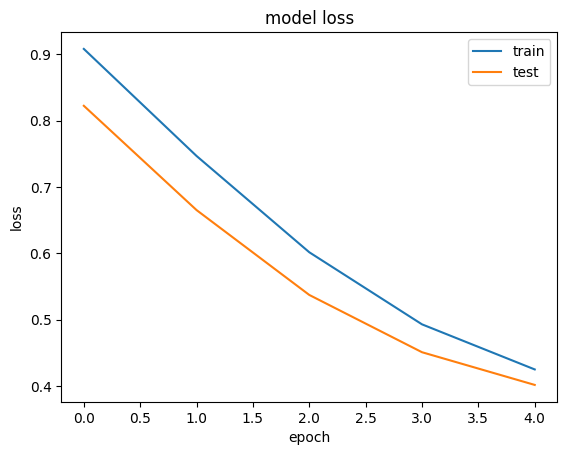

In [30]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

## Evaluation

In [42]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

In [41]:
predictions = autoencoder.predict(X_valid)
mse = np.mean(np.power(X_valid - predictions, 2), axis=(1, 2, 3))

mse_min = np.min(mse)
mse_max = np.max(mse)

mse_scaled = (mse - mse_min) / (mse_max - mse_min)
mse = mse_scaled

# print(X_valid.shape)
# print(predictions.shape)
# print(y_valid.shape)
print(mse.max(), mse.min())

error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_valid})

error_df.describe()

9/9 [==============================] - 0s 5ms/step
1.0 0.0


,reconstruction_error,true_class
count,257.000000,257.000000
mean,0.782215,0.256809
std,0.171439,0.437726
min,0.000000,0.000000
25%,0.716741,0.000000
50%,0.824694,0.000000
75%,0.900658,1.000000
max,1.000000,1.000000


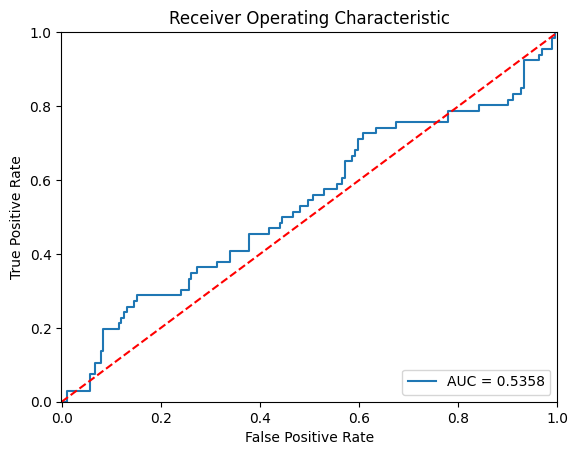

In [43]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

threshold 0.3


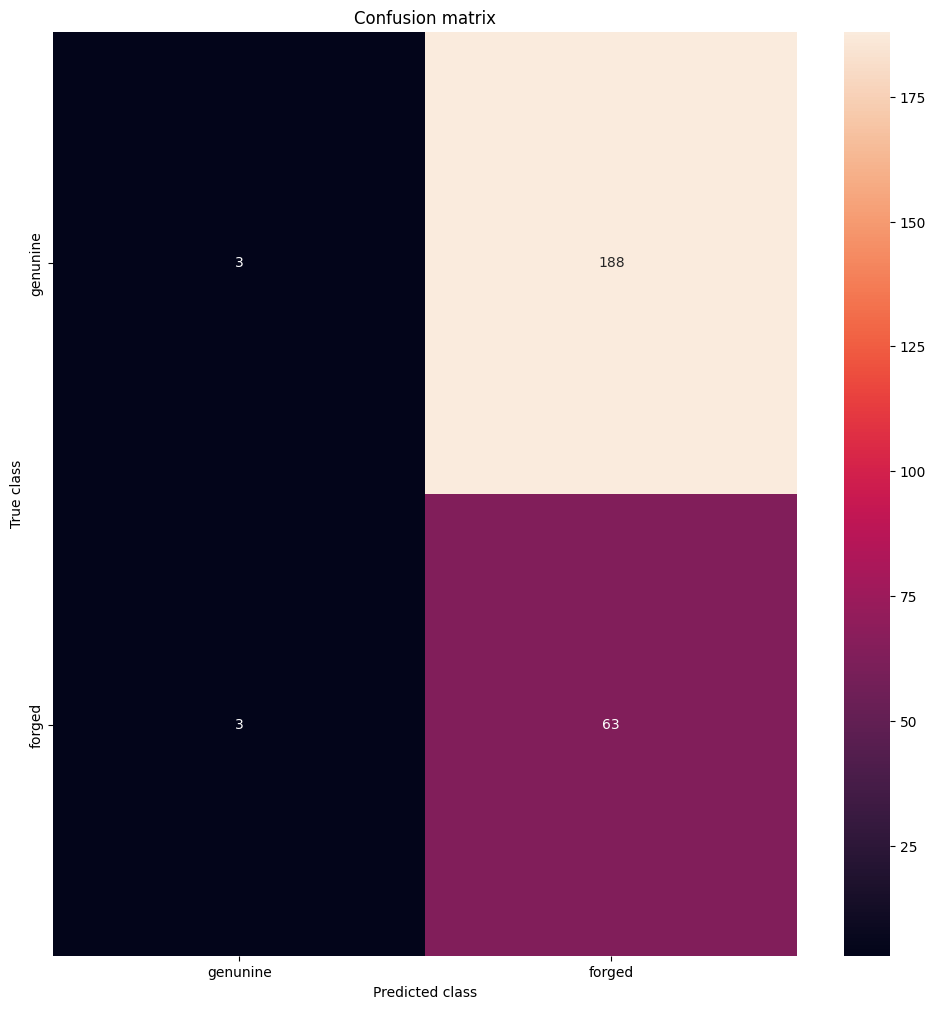

threshold 0.4


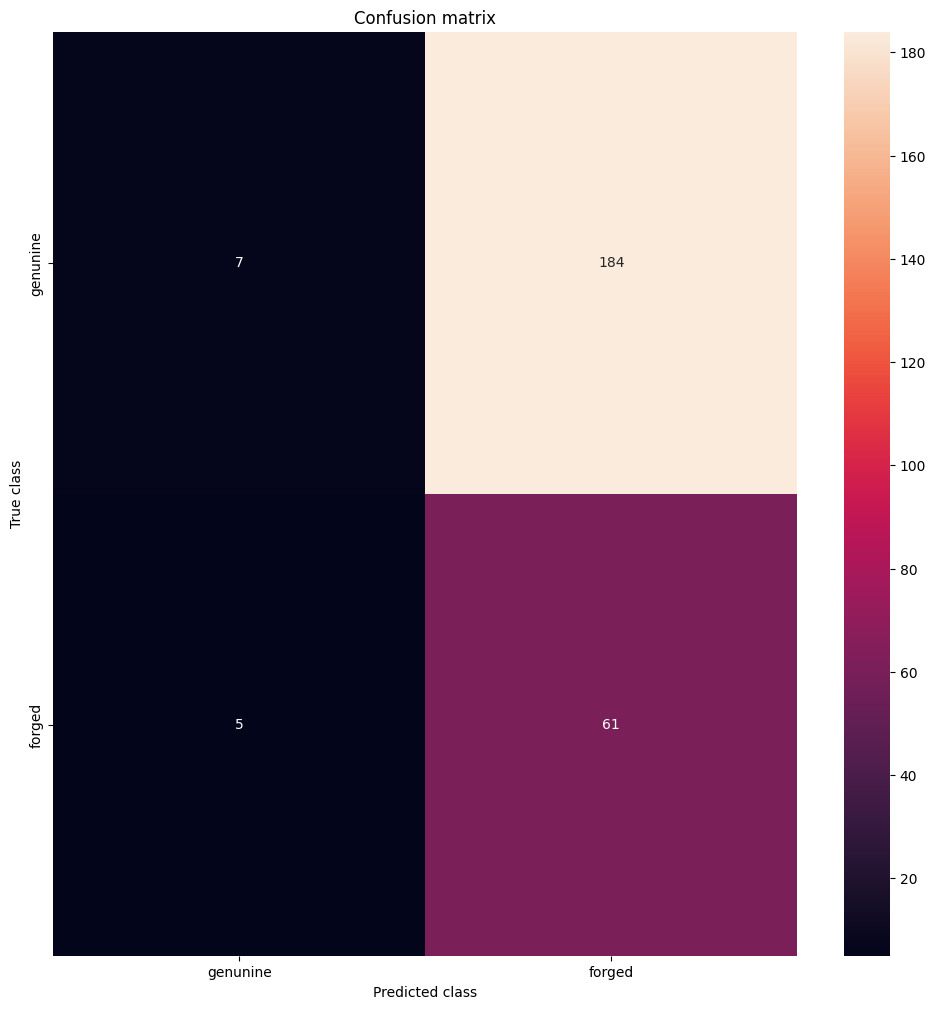

threshold 0.5


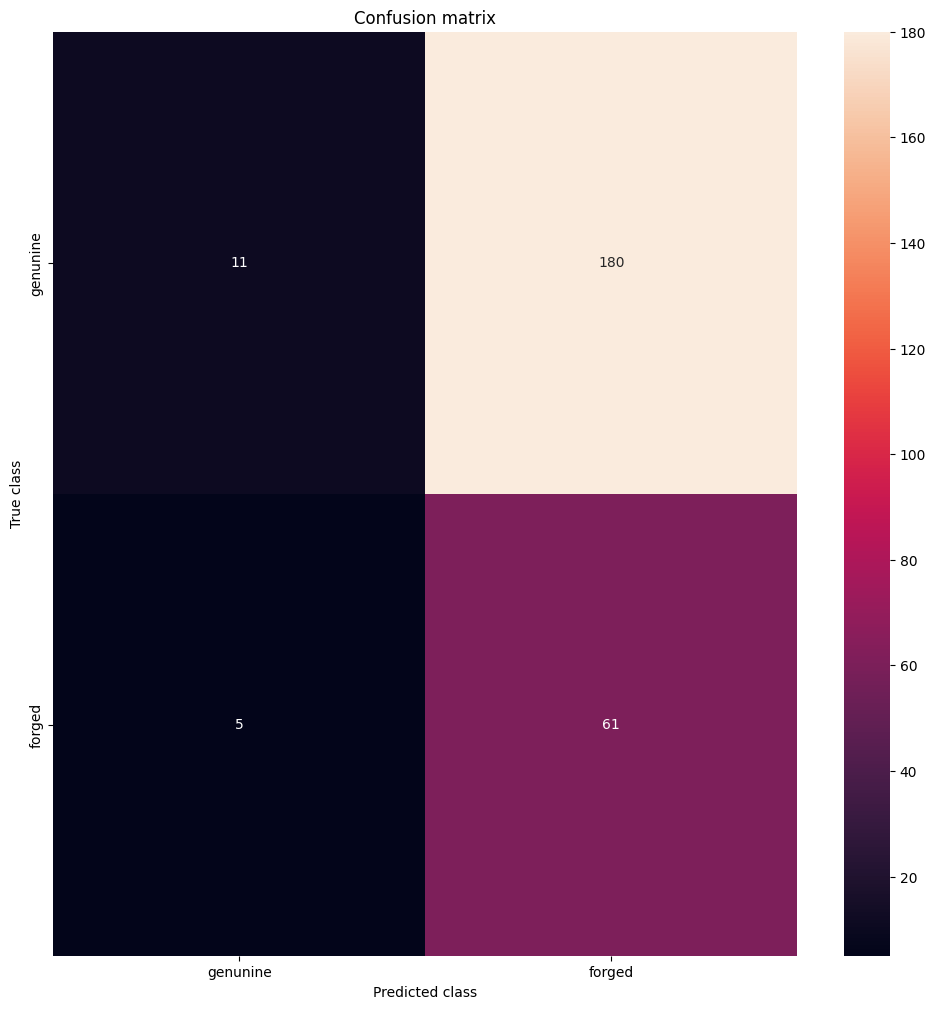

threshold 0.6


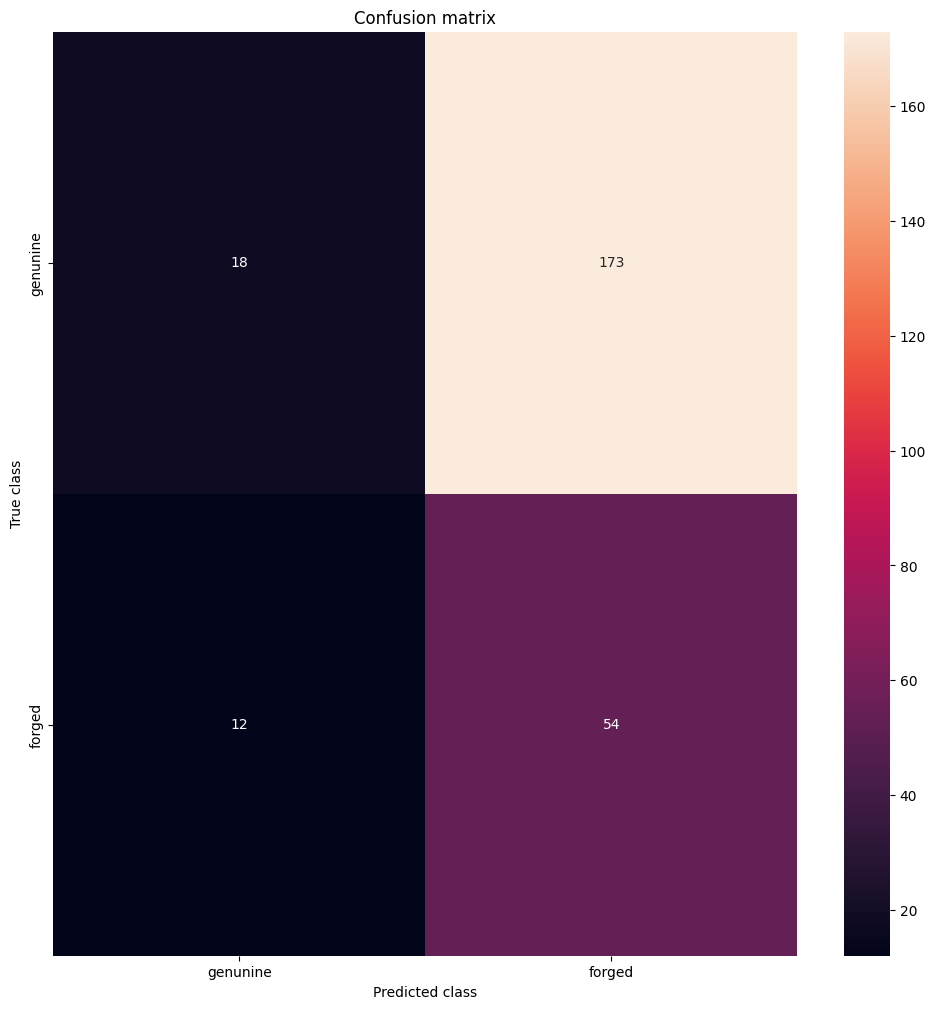

threshold 0.65


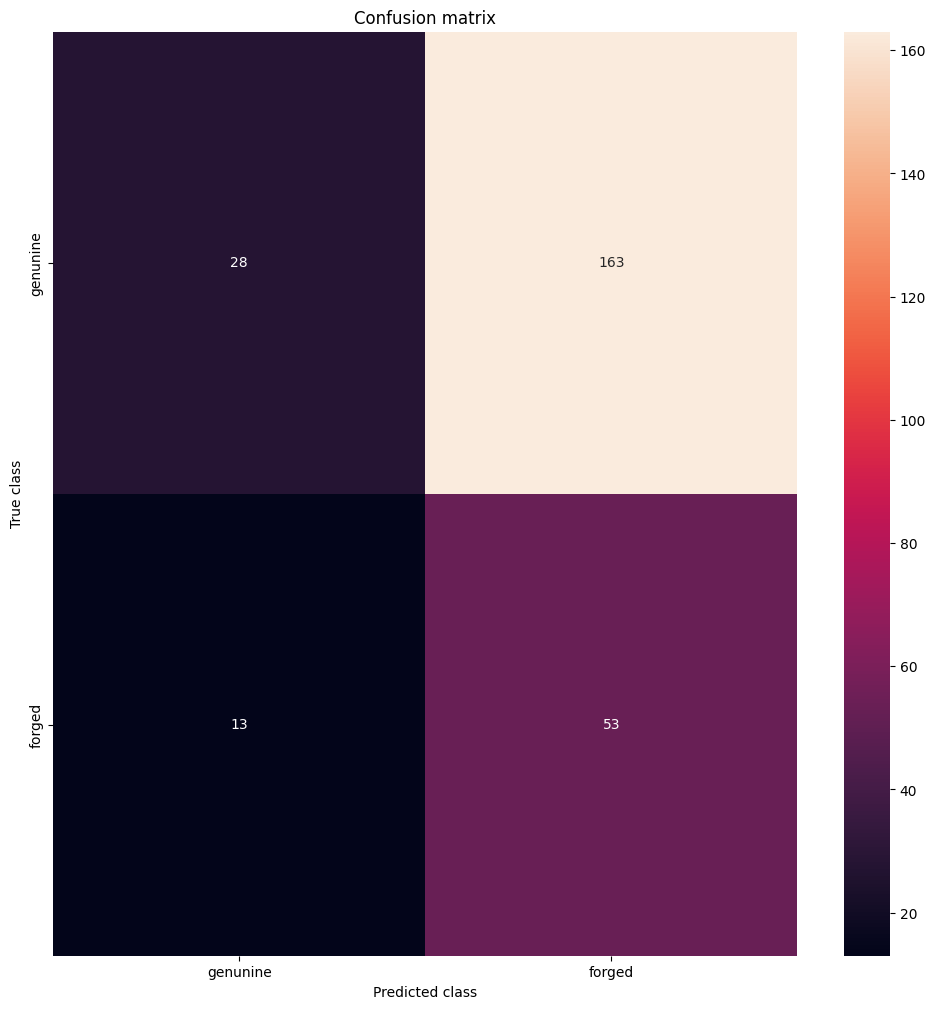

In [46]:
threshold_list = [0.3, 0.4, 0.5, 0.6, 0.65]

for th in threshold_list:
    threshold = th
    y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
    conf_matrix = confusion_matrix(error_df.true_class, y_pred)

    print('threshold', threshold)
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()